In [166]:
!pip install yfinance hmmlearn

In [167]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM

# For better plot styling
sns.set(style="darkgrid")
%matplotlib inline

/tmp/ipython-input-168-4256404468.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('SPY', start='2013-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


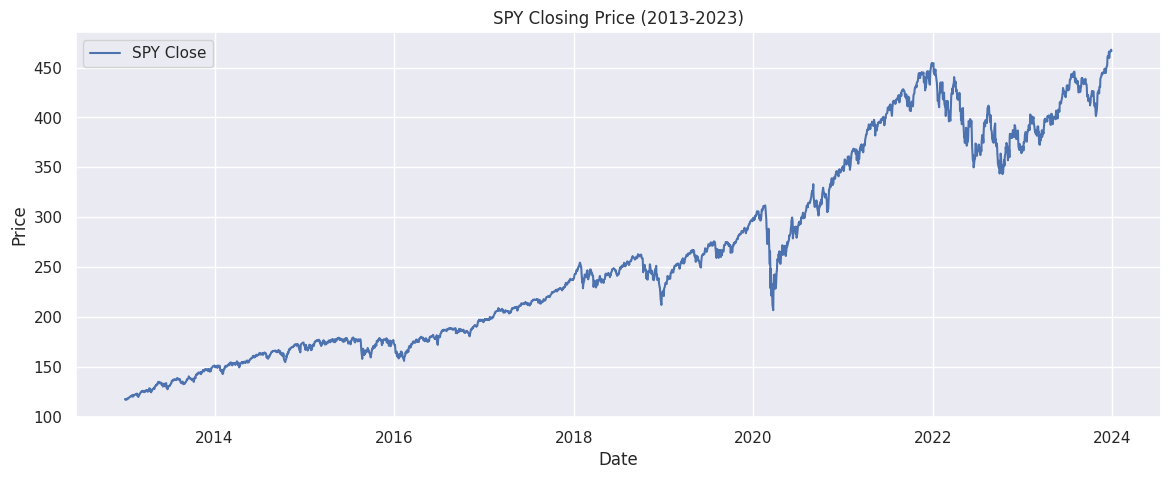

In [168]:
df = yf.download('SPY', start='2013-01-01', end='2023-12-31')
df = df[['Close']].copy()
df.dropna(inplace=True)

# Plot closing prices
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Close'], label='SPY Close')
plt.title("SPY Closing Price (2013-2023)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [169]:
df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))
df['Volatility'] = df['LogRet'].rolling(window=10).std()
df['Momentum'] = df['Close'] - df['Close'].shift(10)
df.dropna(inplace=True)

# Feature matrix
features = df[['LogRet', 'Volatility', 'Momentum']]

In [170]:
model = GaussianHMM(n_components=3, covariance_type='full', n_iter=2000, random_state=42, verbose=True)
model.fit(features)

# Predict regimes
df['Regime'] = model.predict(features)

         1    3300.21258822             +nan
         2   10510.52359466   +7210.31100644
         3   10937.72447818    +427.20088352
         4   11243.11899089    +305.39451271
         5   11421.10549441    +177.98650351
         6   11496.47517643     +75.36968202
         7   11534.57228872     +38.09711229
         8   11566.47238332     +31.90009460
         9   11599.29749808     +32.82511476
        10   11615.28591135     +15.98841327
        11   11622.80965735      +7.52374600
        12   11628.04756411      +5.23790676
        13   11632.07453693      +4.02697282
        14   11635.48388760      +3.40935067
        15   11638.62291081      +3.13902320
        16   11641.67264134      +3.04973054
        17   11644.72412764      +3.05148629
        18   11647.83336478      +3.10923714
        19   11651.04594286      +3.21257808
        20   11654.39880466      +3.35286180
        21   11657.90991062      +3.51110596
        22   11661.56673341      +3.65682279
        23

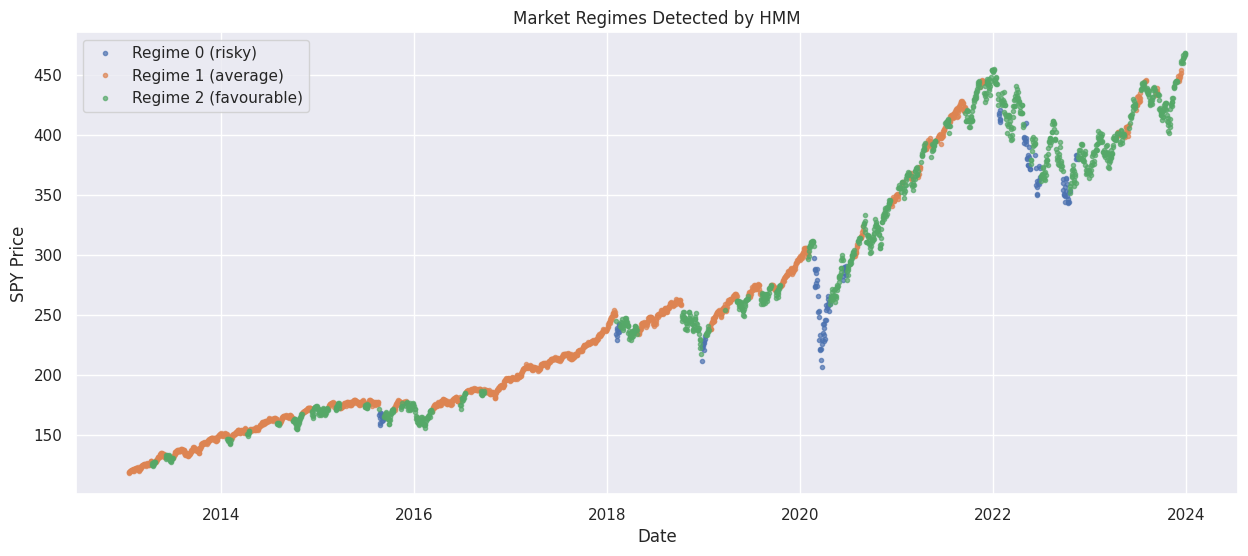

In [171]:
plt.figure(figsize=(15, 6))
colors = ['red', 'green', 'blue']

regime_labels = {
    0: "risky",
    1: "average",
    2: "favourable"
}

for i in range(model.n_components):
    idx = (df['Regime'] == i)
    label = f"Regime {i} ({regime_labels[i]})"
    plt.plot(df.index[idx], df['Close'][idx], '.', label=label, alpha=0.7)

plt.title("Market Regimes Detected by HMM")
plt.xlabel("Date")
plt.ylabel("SPY Price")
plt.legend()
plt.show()

<Axes: title={'center': 'Strategy vs Buy & Hold'}, xlabel='Date'>

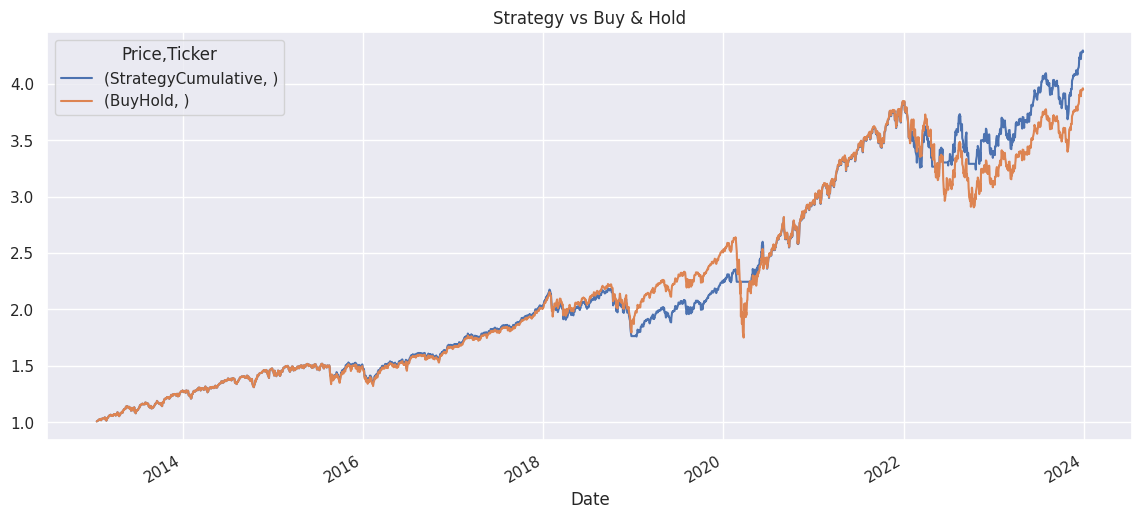

In [172]:
# 6. Simple regime-based strategy
# Let's say Regime 0 is bearish, avoid investing there
df['Returns'] = df['Close'].pct_change()
df['Signal'] = (df['Regime'] != 0).astype(int)  # Risk-off in regime 0
df['Strategy'] = df['Signal'].shift(1) * df['Returns']
df.dropna(inplace=True)

# Cumulative performance
df['StrategyCumulative'] = (1 + df['Strategy']).cumprod()
df['BuyHold'] = (1 + df['Returns']).cumprod()

df[['StrategyCumulative', 'BuyHold']].plot(figsize=(14, 6), title="Strategy vs Buy & Hold")

In [173]:
sharpe = df['Strategy'].mean() / df['Strategy'].std() * np.sqrt(252)
print(f"Strategy Sharpe Ratio: {sharpe:.2f}")

Strategy Sharpe Ratio: 1.06
